In [18]:
using Pkg
Pkg.activate(".")

  Activating project at `~/git/mine/MathematicalEngineeringDeepLearning/Julia/makie_env`


In [26]:
using Lighthouse, CairoMakie, LaTeXStrings

In [35]:
function adapted_conf_mat!(subfig::FigurePosition, confusion::NumberMatrix,
                                class_labels::AbstractVector{String},
                                normalize_by::Union{Symbol,Nothing}=nothing;
                                annotation_text_size=20, colormap=:Blues)
    nclasses = length(class_labels)
    if size(confusion) != (nclasses, nclasses)
        throw(ArgumentError("Labels must match size of square confusion matrix. Found $(nclasses) labels for an $(size(confusion)) matrix"))
    end
    title = "Confusion Matrix"
    if !isnothing(normalize_by)
        normdim = get((Row=2, Column=1), normalize_by) do
            throw(ArgumentError("normalize_by must be :Row, :Column, or `nothing`; found: $(normalize_by)"))
        end
        confusion = round.(confusion ./ sum(confusion; dims=normdim); digits=3)
        title = "$(string(normalize_by))-Normalized Confusion"
    end
    class_indices = 1:nclasses
    text_theme = get_theme(subfig, :ConfusionMatrix, :Text; textsize=annotation_text_size)
    heatmap_theme = get_theme(subfig, :ConfusionMatrix, :Heatmap; nan_color=(:black, 0.0))
    axis_theme = get_theme(subfig, :ConfusionMatrix, :Axis; xticklabelrotation=pi / 4,
                           titlealign=:left, title,
                           xlabel="Elected Class", ylabel="Predicted Class",
                           xticks=(class_indices, class_labels),
                           yticks=(class_indices, class_labels),
                           aspect=AxisAspect(1))

    ax = Axis(subfig; axis_theme...)

    hidedecorations!(ax; label=false, ticklabels=false, grid=false)
    ylims!(ax, nclasses + 0.5, 0.5)
    tightlimits!(ax)
    plot_bg_color = to_color(ax.backgroundcolor[])
    crange = isnothing(normalize_by) ? (0.0, maximum(filter(!isnan, confusion))) :
             (0.0, 1.0)
    nan_color = to_color(heatmap_theme.nan_color[])
    cmap = to_colormap(to_value(pop!(heatmap_theme, :colormap, colormap)))
    heatmap!(ax, confusion'; colorrange=crange, colormap=cmap, nan_color=nan_color,
             heatmap_theme...)
    text_color = to_color(to_value(pop!(text_theme, :color, :black)))
    function label_color(i, j)
        c = confusion[i, j]
        bg_color = if isnan(c) || ismissing(c)
            Makie.Colors.alpha(nan_color) <= 0.0 ? plot_bg_color : nan_color
        else
            Makie.interpolated_getindex(cmap, c, crange)
        end
        return high_contrast(bg_color, text_color)
    end
    annos = vec([(string(confusion[i, j]), Point2f(j, i))
                 for i in class_indices, j in class_indices])
    colors = vec([label_color(i, j) for i in class_indices, j in class_indices])
    text!(ax, annos; align=(:center, :center), color=colors, textsize=annotation_text_size,
          text_theme...)
    return ax
end


LoadError: UndefVarError: FigurePosition not defined

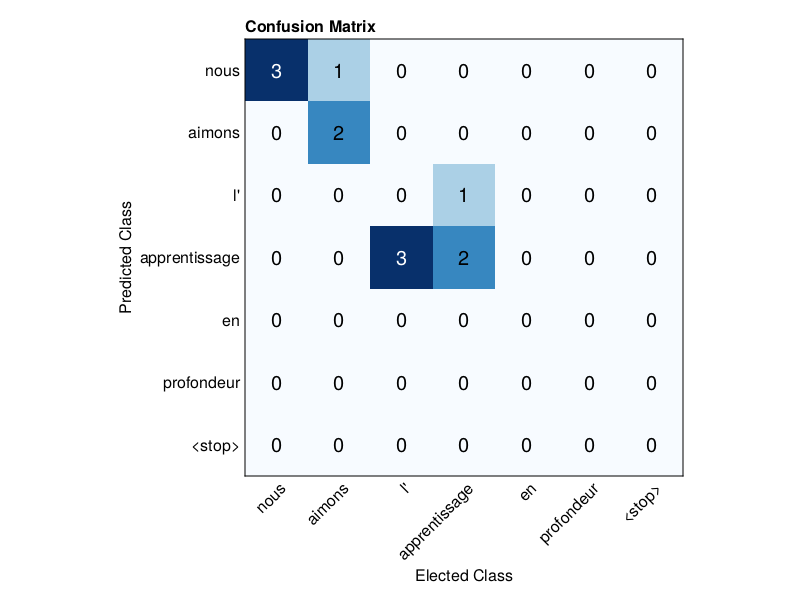

In [33]:
classes = ["nous", "aimons", "l'", "apprentissage","en", "profondeur","<stop>"]
ground_truth =     [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4]
predicted_labels = [1, 1, 1, 1, 2, 2, 4, 4, 4, 4, 4, 3]
confusion = Lighthouse.confusion_matrix(length(classes), zip(predicted_labels, ground_truth))

fig, ax, p = plot_confusion_matrix(confusion, classes)